# **Ricostruzione della soluzione in python**

In [1]:
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')
from IPython.display import display, Markdown

import numpy as np
from matplotlib import pyplot as plt


import math 
import pandas as pd
import os
from scipy.linalg import lu, solve

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_3279/1803959744.py:2: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_3279/1803959744.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


## **Eigen values**

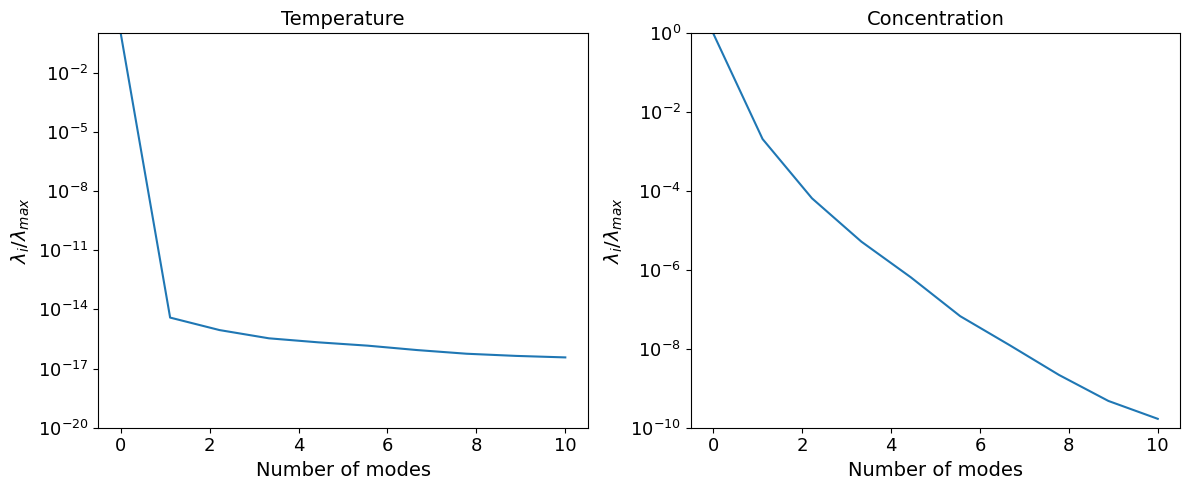

In [21]:
eigenvaluesT = np.loadtxt('TEigenValues.txt')[0:10]
eigenvaluesC = np.loadtxt('CEigenValues.txt')[0:10]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.plot(np.linspace(0,10, 10), eigenvaluesT/(np.max(eigenvaluesT)), linewidth=1.5)
ax1.set_yscale('log')
ax1.set_title('Temperature',fontsize=14)
ax1.set_xlabel('Number of modes',fontsize=14)
ax1.set_ylim(1e-20,1e0)
ax1.set_ylabel('$\lambda_i$/$\lambda_{max}$',fontsize=14)
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)

ax2.plot(np.linspace(0,10, 10), eigenvaluesC/(np.max(eigenvaluesC)))
ax2.set_yscale('log')
ax2.set_title('Concentration',fontsize=14)
ax2.set_xlabel('Number of modes',fontsize=14)
ax2.set_ylim(1e-10,1e0)
ax2.set_ylabel('$\lambda_i$/$\lambda_{max}$',fontsize=14)
ax2.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis='x', labelsize=13)

plt.tight_layout()


#plt.savefig(os.path.join('eigenvalues.pdf'), bbox_inches='tight')

## **Risolutore di ODE**

In [2]:
def lu_gauss(N, A, b):
    """
    @brief LU decomposition, Doolittle algorithm, according to @ref Dahlquist, Germund, Ake Bjorck & Anderson, Ned, Numerical Methods, Prentice Hall, 1974.
    La funzione esegue prima la decomposizione LU della matrice di input (A) memorizzando in essa le matrici inferiori e superiori.
    Quindi, la soluzione del sistema viene eseguita utilizzando la matrice fattorizzata e un metodo di sostituzione all'indietro.
    La soluzione viene memorizzata e restituita nel vettore b.
    NB: Questa funzione può essere utilizzata anche per eseguire solo la decomposizione stessa (ad esempio, per il precondizionamento)
    passando un vettore rhs fittizio.
    
    @param[in] N dimensione
    @param[in] A matrice del sistema lineare (in forma di array 1d)
    @param[in] b vettore RHS
    
    @param[out] b soluzione
    """
    
    A = np.reshape(A, (N, N)).astype(float)
    b = b.astype(float)
    y = np.zeros(N, dtype=float)

    # Decomposizione LU
    for k in range(N):
        for j in range(k, N):
            s = sum(A[k, l] * A[l, j] for l in range(k))
            A[k, j] -= s
        for i in range(k + 1, N):
            s = sum(A[i, l] * A[l, k] for l in range(k))
            A[i, k] = (A[i, k] - s) / A[k, k]

    # Risoluzione del sistema Ly = b
    for i in range(N):
        s = sum(A[i, k] * y[k] for k in range(i))
        y[i] = b[i] - s
        

    # Risoluzione del sistema Ux = y
    for i in range(N-1, -1, -1):
        s = sum(A[i, k] * y[k] for k in range(i + 1, N))
        y[i] = (y[i] - s) / A[i, i]

    return y

### Test funzione LU Gauss

In [3]:
A = np.array([2, 3, 4, 5], dtype=float)
b = np.array([1, 0], dtype=float)
N = 2

# CON LA FUNZIONE lu_gauss
x = lu_gauss(N, A, b)
print(x)

[-2.5  2. ]


In [4]:
#CON IL SOLVER ESISTENTE IN PYTHON
# Matrice A e vettore b
A = np.array([[2, 3], [4,5]])
b = np.array([1, 0])

# Decomposizione LU di A
#P, L, U = lu(A)
# Risoluzione del sistema Ly = Pb
#y = np.linalg.solve(L, np.dot(P, b))
# Risoluzione del sistema Ux = y
#x = np.linalg.solve(U, y)

x = solve(A, b)

print(x)

[-2.5  2. ]


## **ROM - cilindro**

In [5]:
# Per l'equazione della temperatura
H = np.array([[-0.20304529410438, -1.794194167602e-08],
    [-1.7929870999053e-06, -3.0489219756252e-12]
])
J = np.array([[0.86825783440324, 7.6256023299567e-08],
	[7.6256023299567e-08, 6.6972975757376e-15]])
K = np.array([1.6481835446569, 1.4475414767746e-07])
L = np.array([1.7679984122541, 1.5612486870281e-07])

# Per l'equazione della concentrazione
X = np.array([[-6.058719664885, -0.55429841879809, -1.1754548439162, -2.0410958324088, -0.98343912117635],
    [-0.55429841879812, -7.1078459977489, -2.7823021602085, -5.0548352870777, -2.653584549214],
    [-1.1754548439162, -2.7823021602085, -12.290613439702, -12.702887263948, -8.0886618067476],
    [-2.0410958324088, -5.0548352870777, -12.702887263948, -33.729028729911, -21.789917775035],
    [-0.98343912117639, -2.653584549214, -8.0886618067475, -21.789917775034, -29.425141601677]
])
M1 = np.array([[-3.3167101513421, -0.39850493973846, -0.65182466064754, -1.1222420423319, -0.55366283495148],
    [-2.9307440834931e-07, -3.5535919570262e-08, -5.5987819326174e-08, -1.0116273749943e-07, -4.6328212742628e-08]
])
M2 = np.array([[-0.3985611417337, -3.9380323623978, -1.6115630433382, -2.7799745334155, -1.4912224707165],
    [-3.5544209249796e-08, -3.4642504113336e-07, -1.445232940823e-07, -2.4408323183224e-07, -1.3337395181765e-07]
])
M3 = np.array([[-0.65174302280484, -1.6116576193174, -6.8076834247023, -7.1193214575871, -4.5027775683261],
    [-5.5972426217128e-08, -1.4455322960431e-07, -5.9998315278438e-07, -6.2965526325548e-07, -3.9690279687705e-07]
])
M4 = np.array([[-1.1223060338343, -2.7798877039665, -7.1193950203681, -18.831524866587, -12.2698543299],
    [-1.0120230332024e-07, -2.4407872646593e-07, -6.2969983736467e-07, -1.6629343258041e-06, -1.0845633073539e-06]
])
M5 = np.array([[-0.55359365772032, -1.4913275143428, -4.5026623866635, -12.269923156162, -16.442875824631],
    [-4.6293149395284e-08, -1.3342830154277e-07, -3.9689351139282e-07, -1.0846151646332e-06, -1.4511876233436e-06]
])
N1 = np.array([[3.4015975737584e-05, -6.5318871137904e-05, 7.9888352752989e-05, -6.148735777728e-05, 6.8239592556045e-05],
    [-1.8392671600485e-10, 2.3356095633567e-10, -2.5349867630452e-10, 1.8121640915479e-10, -2.0738347467606e-10]
])
N2 = np.array([[-9.117032807446e-06, 5.7243333378549e-05, -9.7984971443193e-05, 8.3981065320342e-05, -9.8802748843154e-05],
    [2.4743943005571e-10, -3.475158687674e-10, 3.1861661928719e-10, -2.6762904050654e-10, 2.9747303612563e-10]
])
N3 = np.array([[-1.7488873623134e-06, -3.4095773083916e-06, 6.0183572405547e-05, -7.6339529240589e-05, 1.0397213006715e-04],
    [-2.8068676231522e-10, 3.5444411763358e-10, -3.7278299418121e-10, 2.5020144317844e-10, -2.9717264875267e-10]
])

N4 = np.array([[2.5028477172353e-06, -2.8486911934598e-06, -2.7786900308149e-06, 3.9684693061977e-05, -6.9436717580297e-05],
    [2.2971621382409e-10, -2.8332830649735e-10, 2.9507288798914e-10, -2.2405167954849e-10, 2.0127967514603e-10]
])



P =np.array([1.3561215930268, 0.76462117999943, 0.432354947383 , 0.45302040100184, 0.28893362630681])

 
 
basesC_average_volume =np.array([0.43344719229789, 0.24439025626201, 0.1381904388094, 0.14479558608727, 0.092349734512828])


## **Equazioni**
Temperatura: 
$$
\frac{da_j(t)}{dt} = \frac{\alpha}{L^2} \sum_{n=1}^{N_T} H_{ij}a_i(t) + QL_j + \frac{\tau_T}{L^2} \sum_{i=1}^{N_T} J_{ji}a_i(t) - \frac{\tau_T T_{BC}}{L^2} K_j \quad j = 1, \dots, N_T
$$
$$
\begin{align*}
H_{ji} &= \langle \phi_j(\mathbf{x}), \nabla^2 \phi_i(\mathbf{x}) \rangle_{L^2} \\
L_j &= \langle \phi_j(\mathbf{x}) \rangle_{L^2} \\
J_{ji} &= \langle \phi_j(\mathbf{x}), \phi_i(\mathbf{x}) \rangle_{L^2, \Gamma_1} \\
K_j &= \langle \phi_j(\mathbf{x}) \rangle_{L^2, \Gamma_1}\\
T_{BC} & = 2000 °C
\end{align*}
$$

Concentrazione: 
$$
\frac{db_j(t)}{dt} = \frac{1}{R^2} \left( D^0 - \alpha^D T^0 \right) \sum_{i=1}^{N_C} b_i(t) X_{ij} + \frac{1}{R^2} \alpha^D \sum_{k=1}^{N_T} \sum_{i=1}^{N_C} a_k(t) b_i(t) M_{jki}
+ \frac{1}{R^2} \alpha^{D} \sum_{k=1}^{N_T} \sum_{i=1}^{N_C} a_k(t) b_i(t) N_{jki} + SP_j \quad j = 1, \dots, N_C
$$
dove: 
$$

X_{ji} = \langle \phi_j(\mathbf{x}), \nabla \cdot [\mathbf{G} \nabla \phi_i(\mathbf{x})] \rangle_{L^2} \\
M_{jki} = \langle \phi_j(\mathbf{x}), (\phi_k(\mathbf{x}), [\mathbf{G} \nabla \phi_i(\mathbf{x})]) \rangle_{L^2} \\
N_{jki} = \langle \phi_j(\mathbf{x}), [\nabla \phi_k(\mathbf{x}), \mathbf{G} \nabla \phi_i(\mathbf{x})] \rangle_{L^2} \\
P_j = \langle \phi_j(\mathbf{x}) \rangle_{L^2}
$$

Linearizzazione del coefficiente di diffusione: 
$$
D = D^0 + \alpha^D (T-T^0)
$$
dove $\alpha^D$ è la derivata partialze del coefficiente di diffusione rispetto a T e valutata in $T^0$

## **Turnbull**

In [6]:
def turnbull_diffusion(fission_rate):
    boltzmann_constant=1.380649e-23
    temperature = 2080
    d1_sciantix = 7.6e-10 * np.exp(-4.86e-19 / (boltzmann_constant * temperature))
    d2_sciantix = 4.0 * 1.41e-25 * np.sqrt(fission_rate) * np.exp(-1.91e-19 / (boltzmann_constant * temperature))
    d3_sciantix = 8.0e-40 * fission_rate
    diff_turnbull_sciantix = d1_sciantix + d2_sciantix + d3_sciantix
    return diff_turnbull_sciantix


def alphaD (fission_rate):
    boltzmann_constant=1.380649e-23
    temperature = 2080
    diff_d1 = ((2.675e-5 * np.exp(-4.86e-19 / (boltzmann_constant * temperature)))/(pow(temperature,2)));
    diff_d2 = ((9.1858e-21*np.sqrt(fission_rate)*np.exp(-1.91e-19 / (boltzmann_constant * temperature)))/(pow(temperature,2)));
    alphaD = diff_d1+diff_d2;
    return alphaD

### **Coefficienti**

$$
\frac{da_j(t)}{dt} = C_1 \sum_{n=1}^{N_T} H_{ij}a_i(t) + C_2 L_j + C_7 \sum_{i=1}^{N_T} J_{ji}a_i(t) - C_6 K_j \quad j = 1, \dots, N_T
$$
$$
C_1 = \frac{\alpha}{L^2}, \\
C_2 = Q, \\
C_7 = \frac{\tau_T}{L^2}, \\
C_6 = \frac{\tau_T T_{BC}}{L^2}.
$$

$$
\frac{db_j(t)}{dt} = C_3 \sum_{i=1}^{N_C} b_i(t) X_{ij} + C_4 \sum_{k=1}^{N_T} \sum_{i=1}^{N_C} a_k(t) b_i(t) M_{jki}
+ C_4 \sum_{k=1}^{N_T} \sum_{i=1}^{N_C} a_k(t) b_i(t) N_{jki} + C_6 P_j \quad j = 1, \dots, N_C \\

C_3 = \frac{\left( D^0 - \alpha^D \cdot  T^0 \right)}{R^2}, \\
C_4 = \frac{\alpha^D}{R^2} , \\
C_5 = S.
$$

In [7]:
thermal_diffusivity = 5e-07
fission_heat = 7.27e-18
grain_length = 1e-03
grain_radius = 1e-05
tau = 1 
#temperature_bc = 2000 
T0 = 2080

def heat_source (fission_heat, fission_rate):
    heat_source = fission_heat * fission_rate
    return heat_source

def gas_source (fission_rate, fission_yield):
    gas_source = fission_rate * fission_yield
    return gas_source


def C1(thermal_diffusivity, grain_length):                                        #Moltiplica H
    return thermal_diffusivity / math.pow(grain_length, 2) 
# C2
def C2(fission_heat, fission_rate):                                                #Moltiplica L
    return heat_source(fission_heat, fission_rate)

# C3
def C3(T0, grain_radius, fission_rate):                                             #Moltiplica X      
    return (turnbull_diffusion(fission_rate) - alphaD(fission_rate) * T0) / math.pow(grain_radius, 2)

# C4
def C4(fission_rate, grain_radius):                                     #Moltiplica M e N
    return alphaD(fission_rate) / math.pow(grain_radius, 2)

# C5                                                                      #Moltiplica P
def C5(fission_rate, fission_yield):
    return gas_source(fission_rate, fission_yield)

# C6
def C6(tau, temperature_bc, grain_length):                          #Moltiplica K - penalty
    return (tau * temperature_bc) / math.pow(grain_length, 2)

# C7
def C7(tau, grain_length):                                             #Moltiplica J - penalty
    return tau / math.pow(grain_length, 2)



### **Temporal loop**

Temperatura
$$
\left( I - C_1 \Delta t \mathbf{H} - C_7 \Delta t \mathbf{J} \right) = C_2 \Delta t \mathbf{L} - C_6 \mathbf{K}
$$

Concentrazione: 
$$
\left( I - C_3 \Delta t \mathbf{X} - C_4 \Delta t a_i^T \mathbf{M} - C_4 \Delta t a_i^T \mathbf{N}\right)  = C_5 \Delta t \mathbf{P}
$$

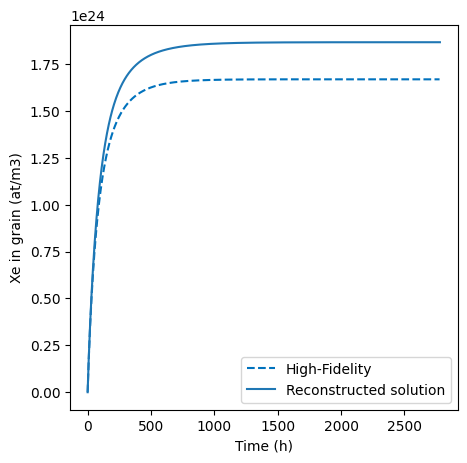

In [8]:
dimT = 2
dimC = 5
initial_condition = np.zeros((dimT+dimC))
lhs_T = np.zeros((dimT, dimT))
rhs_T = np.zeros((dimT))
I_T = np.eye(dimT)

lhs_C = np.zeros((dimC, dimC))
rhs_C = np.zeros((dimC))
I_C = np.eye(dimC)

# Time loop
t_end = (2777.7778*60*60)  # end time
time_step = 1000 #quanti time step voglio
dt = t_end/time_step  # time step
t = 0.0  # current time
step = 1
solution_vector = np.zeros((int(time_step)+2,))

#initial conditions
temperature = 2000
fission_rate = 3e19
fission_yield = 0.24


while t <= t_end:
    # LHS temperatura
    for i in range(dimT):
        for j in range(dimT):
            #lhs_T[i, j] = I_T[i, j] - C1(thermal_diffusivity, grain_length) * dt * H[i, j] - C7(tau, grain_length) * dt * J[i, j]
            lhs_T[i, j] = I_T[i, j] - C1(thermal_diffusivity, grain_length) * dt * H[i, j]
            

    # RHS temperatura
    for i in range(dimT):
        #rhs_T[i] = initial_condition[i] + C2(fission_heat, fission_rate) * dt * L[i] - C6(tau, temperature, grain_length) * dt * K[i]
        rhs_T[i] = initial_condition[i] + C2(fission_heat, fission_rate) * dt * L[i]

    x = lu_gauss(dimT, lhs_T.flatten(), rhs_T)


    for i in range(dimC):
        for j in range(dimC):
            lhs_C[i, j] = I_C[i, j] - C3(T0,grain_radius, fission_rate) * dt * X[i, j]
            for k in range(dimT):
                if i == 0:
                    lhs_C[i, j] += -C4(fission_rate, grain_radius) * dt * M1[k, j] * x[k] - C4(fission_rate, grain_radius) * dt * N1[k, j] * x[k]
                elif i == 1:
                    lhs_C[i, j] += -C4(fission_rate, grain_radius) * dt * M2[k, j] * x[k] - C4(fission_rate, grain_radius) * dt * N2[k, j] * x[k]
                elif i == 2:
                    lhs_C[i, j] += -C4(fission_rate, grain_radius) * dt * M3[k, j] * x[k] - C4(fission_rate, grain_radius) * dt * N3[k, j] * x[k]
                elif i == 3:
                    lhs_C[i, j] += -C4(fission_rate, grain_radius) * dt * M4[k, j] * x[k] - C4(fission_rate, grain_radius) * dt * N4[k, j] * x[k]
                elif i == 4:
                    lhs_C[i, j] += -C4(fission_rate, grain_radius) * dt * M5[k, j] * x[k]
    
    # Costruzione di rhs_C
    zz = 0
    for i in range(dimT, dimT + dimC):
        rhs_C[zz] = initial_condition[i] + C5(fission_rate, fission_yield) * dt * P[zz]
        zz += 1

    y = lu_gauss(dimC, lhs_C.flatten(), rhs_C)


    # Aggiornamento di initial_condition con rhs_T
    for i in range(dimT):
        initial_condition[i] = x[i]
        
    # Aggiornamento di initial_condition con rhs_C
    zzz = 0
    for i in range(dimT, dimT + dimC):
        initial_condition[i] = y[zzz]
        zzz += 1

    # Calcolo della soluzione
    solution = 0.0
    for i in range(dimC):
        solution += basesC_average_volume[i] * y[i]
    
    # Store solution in solution vector
    solution_vector[step] = solution

    t += dt 
    step += 1  # increment time step index

high_fidelity=np.loadtxt("volFieldValue.dat")
timeOF=high_fidelity[:,0]/3600 #hour
xeOF=high_fidelity[:,1]*6.022e23

fig, (ax1) = plt.subplots(1,  figsize=(5,5)) 
ax1.plot(timeOF,xeOF, '--',label='High-Fidelity', color='#0072bd', linewidth=1.5)

ax1.plot(np.arange(0, t_end + 2*dt, dt)/(60*60), solution_vector, label = 'Reconstructed solution')
plt.xlabel('Time (h)')
plt.ylabel('Xe in grain (at/m3)')
plt.legend()

Maximum error between SCIANTIX and HF = 11.859301623042775 (%).


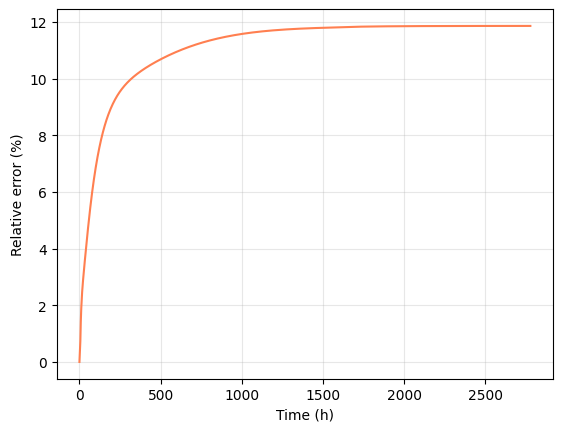

In [9]:
error = np.zeros(np.size(timeOF))
for i in range (1, np.size(timeOF)): 
    error[i]= (abs(xeOF[i]-solution_vector[i])/xeOF[i])*100

plt.plot(figsize=[5,5])
plt.plot(timeOF,error, color='#FF7F50', linewidth=1.5)
plt.grid(which='both', alpha=0.3)
plt.xlabel('Time (h)')
plt.ylabel('Relative error (%)')

print(F'Maximum error between SCIANTIX and HF = {max(error)} (%).')